<a href="https://colab.research.google.com/github/xYaelx/Action-Recognition/blob/master/ResNetSimpleClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget --no-check-certificate --continue \
    https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-12-17 19:05:27--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.218.108.168, 2600:1409:a:788::e59, 2600:1409:a:791::e59, ...
Connecting to download.microsoft.com (download.microsoft.com)|23.218.108.168|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
import os
import zipfile
import shutil  
import re

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:

!ls /tmp/data/train


ls: cannot access '/tmp/data/train': No such file or directory


In [0]:
# !rm -rf /tmp/data

In [0]:
os.rename('/tmp/PetImages', '/tmp/data')
base_dir = '/tmp/data'

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'val')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)


In [0]:
!mv /tmp/data/Dog/*  /tmp/data/train/dogs/  
!mv /tmp/data/Cat/*  /tmp/data/train/cats/  


In [0]:
#move files from train to validation
files = os.listdir(train_dogs_dir)
for f in files:
    validationDogsSearchObj = re.search("5\d\d\d", f)
    if validationDogsSearchObj:
        shutil.move(f'{train_dogs_dir}/{f}', validation_dogs_dir)

files = os.listdir(train_cats_dir)
for f in files:
    validationCatsSearchObj = re.search("5\d\d\d", f)
    if validationCatsSearchObj:
        shutil.move(f'{train_cats_dir}/{f}', validation_cats_dir)

In [0]:
#move files from train to test
files = os.listdir(train_dogs_dir)
for f in files:
    dogsSearchObj = re.search("41\d\d", f)
    if dogsSearchObj:
        shutil.move(f'{train_dogs_dir}/{f}', test_dir)

files = os.listdir(train_cats_dir)
for f in files:
    catsSearchObj = re.search("42\d\d", f)
    if catsSearchObj:
        shutil.move(f'{train_cats_dir}/{f}', test_dir)

In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test images:', len(os.listdir(test_dir)))

!ls {train_dogs_dir} | head -n 5

total training cat images: 11401
total training dog images: 11401
total validation cat images: 1000
total validation dog images: 1000
total test images: 200
0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
print(torch.__version__)
plt.ion()   # interactive mode
torch.cuda.is_available()

1.3.1


True

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [0]:
#corrupted images
#!rm '/tmp/data/train/dogs/11702.jpg'
#!rm '/tmp/data/train/cats/666.jpg'
import glob
print(base_dir)
for filename in glob.iglob(base_dir + '/**/*.jpg', recursive=True):
     if os.path.getsize(filename)==0:
       print(filename)
       os.remove(filename)


/tmp/data
/tmp/data/train/cats/666.jpg
/tmp/data/train/dogs/11702.jpg


In [0]:
data_dir = '/tmp/data' #" 'data'
CHECK_POINT_PATH = 'checkpoint.tar'
SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Classes: ", class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

Classes:  ['cats', 'dogs']
Train image size: 22798
Validation image size: 2000


classes=tensor([0, 0, 0, 0])


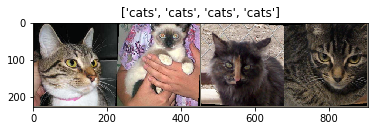

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None):
    since = time.time()
    if checkpoint is None:
            best_model_wts = copy.deepcopy(model.state_dict())
            best_loss = math.inf
            best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                if i % 200 == 199:
                    print('[%d, %d] loss: %.3f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                        phase, epoch_loss, epoch_acc))
        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            print(f'New best model found!')
            print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
            best_loss = epoch_loss
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [0]:
# for param in model_conv.parameters():
#     param.requires_grad = False
#     # Parameters of newly constructed modules have requires_grad=True by default

ct = 0
for child in model_conv.children():
  ct += 1
  # freezes layers 1-6 in the total 10 layers of Resnet50
  if ct < 7:
    for param in child.parameters():
      param.requires_grad = False


num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
    

checkpoint not found


In [0]:
%%time
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)

Epoch 0/2
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1, 199] loss: 0.476
[1, 399] loss: 0.429
[1, 599] loss: 0.409


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting 

[1, 799] loss: 0.398
[1, 999] loss: 0.395


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

[1, 1199] loss: 0.406
[1, 1399] loss: 0.399
[1, 1599] loss: 0.403
[1, 1799] loss: 0.398


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

[1, 1999] loss: 0.390
[1, 2199] loss: 0.393
[1, 2399] loss: 0.388
[1, 2599] loss: 0.386
[1, 2799] loss: 0.385
[1, 2999] loss: 0.385
[1, 3199] loss: 0.388
[1, 3399] loss: 0.384


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


[1, 3599] loss: 0.379
[1, 3799] loss: 0.378
[1, 3999] loss: 0.378
[1, 4199] loss: 0.381
[1, 4399] loss: 0.378


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

[1, 4599] loss: 0.380
[1, 4799] loss: 0.377


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


[1, 4999] loss: 0.379
[1, 5199] loss: 0.378
[1, 5399] loss: 0.376
[1, 5599] loss: 0.377


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting t

[1, 199] loss: 0.095
[1, 399] loss: 0.100
val Loss: 0.0940 Acc: 0.9670
New best model found!
New record loss: 0.09404016795754433, previous record loss: inf
Epoch 1/2
----------
[2, 199] loss: 0.315
[2, 399] loss: 0.416


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))


[2, 599] loss: 0.401


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3368026112 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

[2, 799] loss: 0.376
[2, 999] loss: 0.365
[2, 1199] loss: 0.371


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


[2, 1399] loss: 0.363


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


[2, 1599] loss: 0.360
[2, 1799] loss: 0.357
[2, 1999] loss: 0.346
[2, 2199] loss: 0.345


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

[2, 2399] loss: 0.346
[2, 2599] loss: 0.351
[2, 2799] loss: 0.354


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

[2, 2999] loss: 0.354
[2, 3199] loss: 0.361
[2, 3399] loss: 0.366
[2, 3599] loss: 0.373
[2, 3799] loss: 0.378
[2, 3999] loss: 0.375
[2, 4199] loss: 0.373
[2, 4399] loss: 0.372
[2, 4599] loss: 0.370
[2, 4799] loss: 0.373
[2, 4999] loss: 0.377


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

[2, 5199] loss: 0.377
[2, 5399] loss: 0.376
[2, 5599] loss: 0.377
[2, 199] loss: 0.099
[2, 399] loss: 0.107


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting t

val Loss: 0.1061 Acc: 0.9560
Epoch 2/2
----------
[3, 199] loss: 0.408


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


[3, 399] loss: 0.394
[3, 599] loss: 0.414
[3, 799] loss: 0.415
[3, 999] loss: 0.424
[3, 1199] loss: 0.413
[3, 1399] loss: 0.415


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expect

[3, 1599] loss: 0.406
[3, 1799] loss: 0.400
[3, 1999] loss: 0.403


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


[3, 2199] loss: 0.399
[3, 2399] loss: 0.400
[3, 2599] loss: 0.407


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

[3, 2799] loss: 0.412


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

[3, 2999] loss: 0.407
[3, 3199] loss: 0.405
[3, 3399] loss: 0.404
[3, 3599] loss: 0.403
[3, 3799] loss: 0.404
[3, 3999] loss: 0.403
[3, 4199] loss: 0.399
[3, 4399] loss: 0.394
[3, 4599] loss: 0.392
[3, 4799] loss: 0.392
[3, 4999] loss: 0.393


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

[3, 5199] loss: 0.391
[3, 5399] loss: 0.389
[3, 5599] loss: 0.390
[3, 199] loss: 0.061


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting t

[3, 399] loss: 0.069
val Loss: 0.0680 Acc: 0.9755
New best model found!
New record loss: 0.06798307903110981, previous record loss: 0.09404016795754433

Training complete in 6m 52s
Best val Acc: 0.9755 Best val loss: 0.0680
CPU times: user 2min 58s, sys: 20.1 s, total: 3min 19s
Wall time: 6min 51s


In [0]:
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)


In [0]:
model_conv.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  